In [1]:
from lightgbm import LGBMClassifier

In [2]:
import numpy as np

In [3]:
import pandas as pd
#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}') 

Pandas Version: 1.5.3


In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
X_train = pd.read_csv('/home/pedro/TpIAFiuba/Datos/X_train_con_escalado.csv', encoding = 'unicode_escape')
X_test = pd.read_csv('/home/pedro/TpIAFiuba/Datos/X_test_con_escalado.csv', encoding = 'unicode_escape')

y_train = pd.read_csv('/home/pedro/TpIAFiuba/Datos/y_train.csv', encoding = 'unicode_escape').to_numpy().reshape(-1)
y_test = pd.read_csv('/home/pedro/TpIAFiuba/Datos/y_test.csv', encoding = 'unicode_escape').to_numpy().reshape(-1)

In [6]:
X_train = X_train[["DiffWalking", "BMI", "PhysicalHealth", "Diabetic", "SleepTime"]]
X_test = X_test[["DiffWalking", "BMI", "PhysicalHealth", "Diabetic", "SleepTime"]]

In [7]:
len(X_train), len(X_test)

(38312, 16422)

In [8]:
lgbm = LGBMClassifier(random_state=10)

In [9]:
params = [
    {'n_estimators': [80, 100, 120]},
    {'max_depth': [5, 10, 15]},
    {"random_state":[10]},
    {"learning_rate": [0.01, 0.1, 0.3]}
]

In [10]:
gs = GridSearchCV(lgbm, param_grid = params, cv=5, scoring='recall')

In [11]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=10),
             param_grid=[{'n_estimators': [80, 100, 120]},
                         {'max_depth': [5, 10, 15]}, {'random_state': [10]},
                         {'learning_rate': [0.01, 0.1, 0.3]}],
             scoring='recall')

In [12]:
gs.best_params_

{'learning_rate': 0.01}

In [13]:
gs.best_score_

0.5985597796026155

In [14]:
lgbm_clf = gs.best_estimator_

In [15]:
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, random_state=10)

In [16]:
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [17]:
preds = lgbm_clf.predict(X_test)

In [18]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.75      0.69      8211
           1       0.70      0.60      0.64      8211

    accuracy                           0.67     16422
   macro avg       0.68      0.67      0.67     16422
weighted avg       0.68      0.67      0.67     16422



In [19]:
recall_score(y_test, preds)

0.5951772013153087

In [20]:
accuracy_score(y_test, preds)

0.6715381804895871

In [21]:
cm = confusion_matrix(y_test, preds)

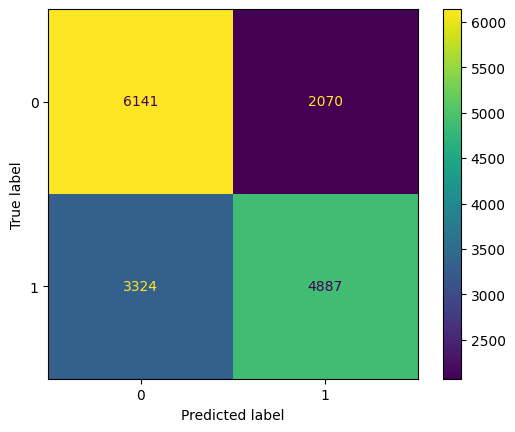

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_clf.classes_)
disp.plot()

In [23]:
from lightgbm import plot_importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

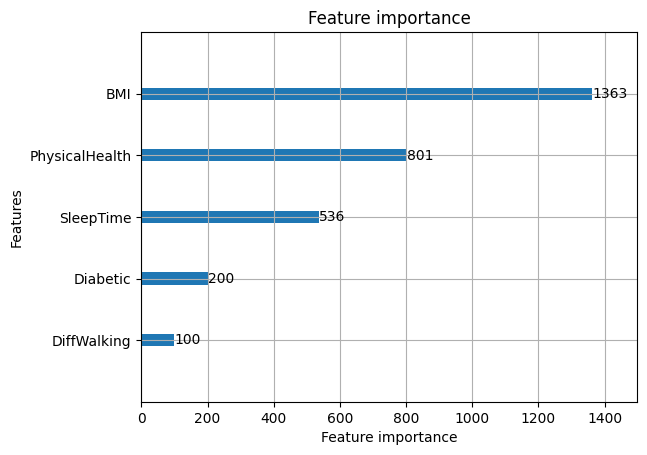

In [24]:
plot_importance(lgbm_clf)

In [25]:
import eli5 as eli

2023-07-08 13:10:44.937280: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 13:10:44.992365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 13:10:44.993683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 13:10:46.169352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
eli.explain_weights(lgbm_clf)

Weight,Feature
0.5468,DiffWalking
0.2942,Diabetic
0.0846,PhysicalHealth
0.0568,BMI
0.0176,SleepTime


Un ejemplo para una prediccion con resultado 0 y otra con resultado 1

In [27]:
eli.explain_prediction(lgbm_clf, np.array(X_test)[1])

Explanation(estimator='LGBMClassifier(learning_rate=0.01, random_state=10)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='x3', weight=0.6810792773339809, std=None, value=1.0), FeatureWeight(feature='x1', weight=0.016611001388551715, std=None, value=-0.2168371987675181), FeatureWeight(feature='<BIAS>', weight=0.004841197268287942, std=None, value=1.0)], neg=[FeatureWeight(feature='x0', weight=-0.21784759522996164, std=None, value=0.0), FeatureWeight(feature='x2', weight=-0.06739057598199581, std=None, value=-0.5496623123140226), FeatureWeight(feature='x4', weight=-0.001931766786731617, std=None, value=0.5350756503276779)], pos_remaining=0, neg_remaining=0), proba=0.6023727756057723, score=0.41536153799213144, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [28]:
y_test[1]

0

In [29]:
eli.explain_prediction(lgbm_clf, np.array(X_test)[10000])

Explanation(estimator='LGBMClassifier(learning_rate=0.01, random_state=10)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='x0', weight=0.667406654711732, std=None, value=1.0), FeatureWeight(feature='x3', weight=0.23188225507586602, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=0.004841197268287942, std=None, value=1.0)], neg=[FeatureWeight(feature='x2', weight=-0.03873163877909447, std=None, value=-0.5496623123140226), FeatureWeight(feature='x1', weight=-0.009997754600910354, std=None, value=2.359879679357874), FeatureWeight(feature='x4', weight=-0.006374157340244415, std=None, value=-0.7054579844895085)], pos_remaining=0, neg_remaining=0), proba=0.7003629005898411, score=0.8490265563356367, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [30]:
y_test[10000]

1

In [31]:
from joblib import dump

In [32]:
dump(lgbm_clf, '/home/pedro/TpIAFiuba/Modelos/LGBM_Model_featuresImp.joblib')

['/home/pedro/TpIAFiuba/Modelos/LGBM_Model_featuresImp.joblib']